In [3]:
import pandas as pd
from autorank import autorank, plot_stats, create_report, latex_table
DEFAULT_PATH = "/workspaces/Ribeiro2025/art2"

model_rename_dict = {
    'auto_arima': 'AutoArima',
    'auto_ets': 'AutoETS',
    'auto_theta': 'AutoTheta',
    'chronos-t5-base': 'ChronosT5Base',
    'lagllama': 'LagLlama',
    'moirai-base': 'MoiraiBase',
    'moirai-moe-base': 'MoiraiMoeBase',
    'timesfm-1.0': 'TimesFM',
    'tinytimemixer-r1': 'TinyTimeMixer'
}

# Preprocess results

In [4]:
df: pd.DataFrame = pd.read_csv(f'{DEFAULT_PATH}/metric_agg.csv')
df = df.groupby(['Model', 'Disease', 'Context', 'Prediction']).median().reset_index()

In [5]:
melted_df = df.melt(
    id_vars=['Model', 'Disease', 'Context', 'Prediction'],
    value_vars=['MASE', 'CPRS', 'MSIS', 'NRMSE'],
    var_name='Metric',
    value_name='value'
)

melted_df['Model'] = melted_df['Model'].replace(model_rename_dict)

# Table comparing diseases

In [6]:
pivot_df = melted_df.pivot(index=["Context","Disease", "Metric", "Prediction"], columns=["Model"], values="value")
mean_pivot_df = pivot_df.groupby(["Disease", "Metric"]).mean()
mean_pivot_df = mean_pivot_df.xs('MASE', level='Metric')
mean_pivot_df = mean_pivot_df.reindex(sorted(mean_pivot_df.columns), axis=1)
mean_pivot_df.sort_values(by=["Disease"], axis=0, ascending=True)
def highlight_ranking(s):
    is_min = s == s.min()
    is_second = s == s.nsmallest(2).iloc[-1]    
    return ['font-weight: bold' if v1 else 'font-style: italic' if v2 else '' 
            for v1, v2,  in zip(is_min, is_second)]

(mean_pivot_df
 .style.apply(highlight_ranking, axis=1)
 .format(precision=4)
 .to_latex("outputs/table_evaluated_by_diseases.tex",hrules=True, caption="Point evaluation using MASE metric by disease", label="tab:disease_models_metrics",
                                 siunitx=True, convert_css=True,multirow_align="t", multicol_align="c", position_float="centering", environment="table*")
)

## Table comparing based on CPRS

In [10]:
pivot_df = melted_df.pivot(index=["Context","Disease", "Metric", "Prediction"], columns=["Model"], values="value")
mean_pivot_df = pivot_df.groupby(["Disease", "Metric"]).mean()
mean_pivot_df = mean_pivot_df.xs('CPRS', level='Metric')
mean_pivot_df = mean_pivot_df.reindex(sorted(mean_pivot_df.columns), axis=1)
selected_models = ['AutoArima', 'AutoETS', 'AutoTheta', 'ChronosT5Base', 'LagLlama', 'MoiraiBase', 'MoiraiMoeBase']
mean_pivot_df = mean_pivot_df[selected_models]
mean_pivot_df.sort_values(by=["Disease"], axis=0, ascending=True)
def highlight_ranking(s):
    is_min = s == s.min()
    is_second = s == s.nsmallest(2).iloc[-1]    
    return ['font-weight: bold' if v1 else 'font-style: italic' if v2 else '' 
            for v1, v2,  in zip(is_min, is_second)]
(mean_pivot_df.T
 .style.apply(highlight_ranking, axis=0)
 .format(precision=4)
 .to_latex("outputs/table_probabilistic.tex",hrules=True, caption="Probabilistic evaluation using CPRS metric by disease", label="tab:cprs_disease",
                                 siunitx=True, convert_css=True,multirow_align="t", multicol_align="c", position_float="centering", environment="table*")
)
mean_pivot_df

Model,AutoArima,AutoETS,AutoTheta,ChronosT5Base,LagLlama,MoiraiBase,MoiraiMoeBase
Disease,,,,,,,
CHIKBR,1.439651,1.160430,1.132229,0.816879,0.804980,0.836771,1.317799
DENGBR,1.587129,1.490682,1.405175,1.116940,0.859955,0.956222,1.185325
ESQUBR,0.813729,0.787600,0.828243,0.244088,0.465161,0.274009,2.878767
EXANBR,3.263015,4.615878,5.056808,0.604310,0.741484,0.760036,5.323993
HANSBR,0.135246,0.143956,0.126451,0.129341,0.173145,0.134261,0.303077
HEPABR,0.235251,0.201249,0.205369,0.175384,0.204060,0.189676,0.339428
LEIVBR,0.189618,0.186430,0.215214,0.170407,0.184855,0.171865,0.234894
LEPTBR,0.462426,0.559178,0.506349,0.336885,0.391256,0.333456,0.724132
LTANBR,0.291242,0.341947,0.310418,0.261266,0.286257,0.247332,0.446647


# Table comparing prediction and context

In [11]:
pivot_df = melted_df.pivot(index=["Model","Prediction","Disease", "Metric"], columns=["Context"], values="value")
pivot_df = pivot_df[pivot_df.index.get_level_values('Metric').isin(['CPRS'])]

# TODO: Temporaraly necessary to replace inf values with nan
mean_pivot_df = pivot_df.groupby(['Model',"Prediction"]).mean()

mean_pivot_df = mean_pivot_df.reorder_levels(['Model', 'Prediction',]).sort_index(level=[ 'Prediction', 'Model'])
mean_pivot_df.index.to_list()

def highlight_min(s):
    # Create arrays for different styles
    is_min = s == s.min()
    is_second = s == s.nsmallest(2).iloc[-1]
    is_third = s == s.nsmallest(3).iloc[-1]
    
    # Apply styles using vectorized operations
    return ['font-weight: bold' if v1 else 'text-decoration: underline' if v2 else 'font-style: italic' if v3 else '' 
            for v1, v2, v3 in zip(is_min, is_second, is_third)]

idx = pd.IndexSlice
slice_ = idx[idx[:,12], idx[:]]


import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Create a custom colormap
colors = [(0, "green"), (0.5, "white"), (1, "red")]
n_bins = 100  # Discretizes the interpolation into bins
cmap_name = "custom_cmap"
custom_cmap = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
mean_pivot_df.rename_axis(index={'Prediction': 'P'}, columns={"Context": "C"}, inplace=True)
# mean_pivot_df.rename_axis(index={"Context": "C"}, , inplace=True)
(mean_pivot_df.style
 .background_gradient(axis=0, cmap=custom_cmap, vmin=0, vmax=2, subset=slice_) # RdYlGn
 .background_gradient(axis=0, cmap=custom_cmap, vmin=0, vmax=2, subset=idx[idx[:,24], idx[:]])
 .format(precision=4)
 .to_latex("outputs/table_evaluated_by_prediction_context.tex", hrules=True, caption="MASE for each model and input size", label="tab:models_metrics",
           siunitx=False, convert_css=True, position_float="centering",multicol_align="c" 
           )# sparse_index=False, sparse_columns=False)
) #  multirow_align="t", multicol_align="c",
print(mean_pivot_df)

C                      32        96        168
Model         P                               
AutoArima     12  0.849012  0.548186  1.288689
AutoETS       12  0.671859  0.641977  1.770358
AutoTheta     12  0.704418  0.616033  1.534550
ChronosT5Base 12  0.423243  0.355180  0.311959
LagLlama      12  0.402045  0.371453  0.666354
MoiraiBase    12  0.421516  0.367786  0.409746
MoiraiMoeBase 12  0.872841  0.937535  3.893687
TimesFM       12  0.364636  0.362612  0.358273
TinyTimeMixer 12  0.520909  0.469124  0.969692
AutoArima     24  1.326933  0.603985  1.185769
AutoETS       24  0.835892  0.708356  1.918331
AutoTheta     24  0.907636  0.668375  1.697912
ChronosT5Base 24  0.457584  0.471704  0.340656
LagLlama      24  0.445736  0.421940  0.639797
MoiraiBase    24  0.453756  0.465268  0.480018
MoiraiMoeBase 24  0.926367  1.023805  3.200433
TimesFM       24  0.393334  0.456013  0.371669
TinyTimeMixer 24  0.572958  0.538906  0.726181


# CD plot

In [7]:
df_cd: pd.DataFrame = pd.read_csv(f"{DEFAULT_PATH}/metric_per_window.csv")
df_cd = df_cd.groupby(['Model', 'Disease', 'Context', 'Prediction', 'forecast_start', 'item_id']).median().reset_index()
melted_df_cd = df_cd.melt(
    id_vars=['Model', 'Disease', 'Context', 'Prediction', 'forecast_start', 'item_id'],
    value_vars=['MASE', 'CPRS', 'MSIS', 'NRMSE'],
    var_name='Metric',
    value_name='value'
)
melted_df_cd['Model'] = melted_df_cd['Model'].replace(model_rename_dict)

In [8]:
pivot_df = melted_df_cd.pivot(index=["Context","Disease", "Metric", "Prediction", "item_id", "forecast_start"], columns=["Model"], values="value")
pivot_df

mase_df = pivot_df.xs(('MASE' ), level=('Metric'))

mean_mase_df = mase_df.groupby(level=['Disease', 'item_id']).mean()

result = autorank(mean_mase_df, alpha=0.05, verbose=False, order='ascending')

create_report(result)
latex_table(result)


The statistical analysis was conducted for 9 populations with 221 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We rejected the null hypothesis that the population is normal for the populations TimesFM (p=0.000), ChronosT5Base (p=0.000), MoiraiBase (p=0.000), LagLlama (p=0.000), AutoETS (p=0.000), AutoArima (p=0.000), AutoTheta (p=0.000), TinyTimeMixer (p=0.000), and MoiraiMoeBase (p=0.000). Therefore, we assume that not all populations are normal.
Because we have more than two populations and the populations and some of them are not normal, we use the non-parametric Friedman test as omnibus test to determine if there are any significant differences between the median values of the populations. We use the post-hoc Nemenyi test to infer which differences are significant. We report the median (MD), the median absolute deviation (MAD) and the mean rank (MR) among all populations over the samples. Differences between populations are significant, if the dif

<Figure size 685x400 with 0 Axes>

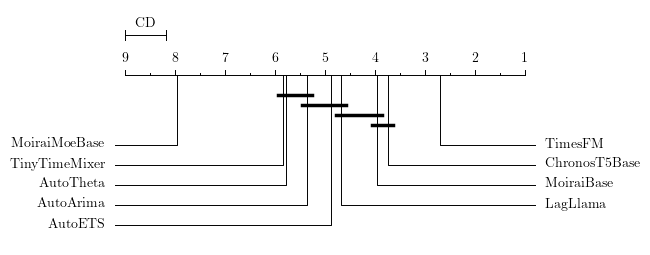

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6.85, 4))
plt.rcParams.update({
    "font.family": "serif",          # Use a serif font like Times New Roman
    "font.serif": ["Times New Roman"],  # Specifically Times New Roman
    "text.usetex": True,             # Use LaTeX for text rendering
    "pgf.texsystem": "pdflatex",     # Ensure we use pdflatex for generating the plot
    "pgf.rcfonts": False,             # Disable the use of rcParams fonts (use LaTeX's fonts)
    "pgf.texsystem": "pdflatex"

})
plot_stats(result=result)
plt.savefig("outputs/autorank_mase2.pdf", bbox_inches='tight')
# dir(plt)
